
# Chewing from accelerometer — counts via active/peaks (strict+gap-fill+anti-isolated)

**What this notebook does**  
- Counts chews from a *single accelerometer* using: envelope gating (baseline + K·MAD), strict peaks, gap-fill in long gaps, non-maximum suppression (NMS), and anti-isolated filtering (the exact methods you requested).  
- Excludes peaks that fall into pauses.  
- Maps BORIS S/E to accelerometer time (**`t_acc = 349.75 + Time`**) and counts BORIS chews via S→E midpoint in-bout.  
- Plots full bouts and 10 s zooms for **P1, P4, P6**, plus **one grouped histogram** (BORIS vs Peaks) for **all 10 bouts**.


In [1]:

# %% Imports & Config
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert, find_peaks, detrend, peak_prominences

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True

# --- Data (no ALT paths)
ACCEL_PATH = r"C:\Users\eleut\OneDrive\Desktop\teraterm_11_08_2025_accelerometer.csv"
BORIS_PATH = r"C:\Users\eleut\OneDrive\Desktop\boris_video3.csv"

# --- Video window
VIDEO_START_ACCEL = 349.75     # mapping: t_acc = 349.75 + BORIS_Time (s)
VIDEO_END_ACCEL   = 930.8

# --- Known bouts (for plots & histogram)
VIDEO_BOUTS = [
    (374.8, 424.8), (428.8, 489.8), (493.8, 532.8), (539.8, 602.8), (607.8, 669.8),
    (674.8, 734.8), (738.8, 794.8), (802.8, 860.8), (866.8, 923.8), (927.8, 930.8),
]
BOUT_IDS_TO_PLOT = [1, 4, 6]   # P1, P4, P6
ZOOM_SECONDS     = 10.0
ZOOM_MARGIN_S    = 0.4

# --- Signal params
F_LO, F_HI, FILT_ORDER = 0.5, 3.0, 4
SMOOTH_S = 0.20

# --- Gating (pauses)
GATE_K       = 2.2
MIN_ON_S     = 2.5
MIN_OFF_S    = 1.5
MIN_PAUSE_S  = 3.0

# --- Peaks (inside active segments)
MIN_PEAK_DISTANCE_S = 0.60
PROMINENCE_MAD_K    = 3.0
HEIGHT_PERC         = 0.60

# --- Gap-fill / Anti-isolated
MAX_GAP_FRAC     = 1.5
FILL_K_HEIGHT    = 0.60
FILL_K_PROM      = 0.80
FILL_MIN_Q       = 0.45
MIN_DIST_FLOOR_S = 0.45
ISOLATION_FRAC   = 2.4
ISO_WEAK_Q       = 0.40



## Utilities (exact methods for gating/peaks)


In [2]:

def parse_time_s(df: pd.DataFrame) -> pd.Series:
    if 'time_s' in df.columns:
        ts = pd.to_numeric(df['time_s'], errors='coerce')
        if np.isfinite(ts).mean() > 0.9:
            return ts
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce')
        if ts.notna().any():
            t0 = ts.dropna().iloc[0]
            return (ts - t0).dt.total_seconds()
    if 't' in df.columns:
        ts = pd.to_numeric(df['t'], errors='coerce')
        if np.isfinite(ts).mean() > 0.9:
            return ts
    raise ValueError("Cannot derive 'time_s'.")

def estimate_fs(t: np.ndarray) -> float:
    dt = np.diff(t); dt = dt[(dt > 0) & np.isfinite(dt)]
    return 1.0/np.median(dt)

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5*fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return b, a

def bandpass(sig, fs, low, high, order):
    b, a = butter_bandpass(low, high, fs, order)
    return filtfilt(b, a, sig)

def moving_average(x, w):
    if w <= 1: return x
    return np.convolve(x, np.ones(w)/w, mode='same')

def mad(x):
    med = np.median(x)
    return np.median(np.abs(x - med)) + 1e-12

# ---- activity/pause gating ----
def activity_mask(env, fs, K=2.2, min_on_s=2.5, min_off_s=1.5):
    w = max(5, int(round(2.0*fs)))
    s = pd.Series(env)
    base = s.rolling(w, center=True, min_periods=max(3, w//3)).median()
    madv = (s - base).abs().rolling(w, center=True, min_periods=max(3, w//3)).median()
    base = base.fillna(method='bfill').fillna(method='ffill').fillna(s.median()).to_numpy()
    madv = (madv.fillna(method='bfill').fillna(method='ffill').fillna((s - s.median()).abs().median()) + 1e-12).to_numpy()
    on = (env > (base + K*madv)).astype(int)
    return _enforce_min_lengths(on, fs, min_on_s, min_off_s).astype(bool)

def _enforce_min_lengths(binary, fs, min_on_s, min_off_s):
    b = binary.copy()
    min_on  = max(1, int(round(min_on_s*fs)))
    min_off = max(1, int(round(min_off_s*fs)))
    i=0
    while i < len(b):
        j=i
        while j < len(b) and b[j]==b[i]: j+=1
        run_len = j-i
        if b[i]==1 and run_len<min_on:  b[i:j]=0
        if b[i]==0 and run_len<min_off: b[i:j]=1
        i=j
    return b

def runs_from_mask(t, mask, value=True, min_len_s=0.0, fs=1.0):
    idx = np.where(mask==value)[0]
    if len(idx)==0: return []
    cuts = np.where(np.diff(idx) > 1)[0]
    starts = [idx[0]] + [idx[c+1] for c in cuts]
    ends   = [idx[c]   for c in cuts] + [idx[-1]]
    segs = []
    for s,e in zip(starts, ends):
        a, b = t[s], t[e]
        if (b-a) >= min_len_s:
            segs.append((a,b))
    return segs

# ---- peaks (strict + helpers) ----
def detect_peaks_strict(env, fs, dist_s=0.60, k_prom=3.0, q_height=0.60):
    prom = k_prom * mad(env)
    hthr = np.quantile(env, q_height)
    dist = max(1, int(round(dist_s * fs)))
    idx, _ = find_peaks(env, distance=dist, prominence=prom, height=hthr)
    return idx

def estimate_period(t_peaks, env_seg, fs):
    if len(t_peaks) >= 4:
        return float(np.median(np.diff(t_peaks)))
    e = env_seg - np.median(env_seg)
    ac = np.correlate(e, e, mode='full')[len(e)-1:]
    lag_min = int(fs*0.4); lag_max = min(len(ac)-1, int(fs*1.8))
    if lag_max <= lag_min+1:
        return 0.9
    ac[:lag_min]=0
    lag = lag_min + np.argmax(ac[lag_min:lag_max+1])
    return max(0.5, min(2.0, lag/fs))

def add_peaks_in_long_gaps(t_seg, env_seg, fs, t_base, T,
                           max_gap_frac=1.5, kH=0.60, kP=0.80, qmin=0.45,
                           min_dist_floor_s=0.45):
    if len(t_base) < 2: return np.array([])
    idx_base = np.searchsorted(t_seg, t_base)
    idx_base = np.clip(idx_base, 0, len(t_seg)-1)
    w = max(5, int(round(2.5*fs)))
    s = pd.Series(env_seg)
    base = s.rolling(w, center=True, min_periods=max(3, w//3)).median()
    madv = (s - base).abs().rolling(w, center=True, min_periods=max(3, w//3)).median()
    base = base.fillna(method='bfill').fillna(method='ffill').fillna(s.median()).to_numpy()
    madv = (madv.fillna(method='bfill').fillna(method='ffill').fillna((s - s.median()).abs().median()) + 1e-12).to_numpy()
    min_dist = max(min_dist_floor_s, 0.60*T)
    dfill = max(1, int(round(min_dist*fs)))
    extra = []
    for a,b in zip(idx_base[:-1], idx_base[1:]):
        dt = t_seg[b] - t_seg[a]
        if dt <= max_gap_frac*T: 
            continue
        s1 = a + int(round(0.15*fs))
        e1 = b - int(round(0.15*fs))
        if e1 <= s1 or (e1-s1) < int(0.6*fs): 
            continue
        env_win = env_seg[s1:e1]
        base_w = base[s1:e1]; mad_w = madv[s1:e1]
        q70 = np.quantile(env_win, 0.70)
        hthr = np.maximum(base_w + kH*mad_w, qmin*q70)
        pthr = np.maximum(kP*mad_w, 0.10*q70)
        idx_rel, _ = find_peaks(env_win, distance=dfill, height=hthr, prominence=pthr)
        if len(idx_rel)==0: 
            continue
        max_new = max(1, int(np.floor(dt/T)) - 1)
        if len(idx_rel) > max_new:
            prom = peak_prominences(env_win, idx_rel)[0]
            keep = np.argsort(prom)[::-1][:max_new]
            idx_rel = idx_rel[keep]
        extra.extend((s1 + idx_rel).tolist())
    extra = np.unique(np.asarray(extra, dtype=int))
    return t_seg[extra] if len(extra) else np.array([])

def nms_distance_union(t_seg, env_seg, fs, t_a, t_b, min_dist_s):
    if len(t_a)==0 and len(t_b)==0: 
        return np.array([])
    t_all = np.sort(np.unique(np.concatenate([x for x in [t_a, t_b] if len(x)>0])))
    if len(t_all) <= 1: return t_all
    d = max(1, int(round(min_dist_s*fs)))
    keep = [t_all[0]]
    for tt in t_all[1:]:
        if (tt - keep[-1])*fs <= d:
            va = np.interp(keep[-1], t_seg, env_seg)
            vb = np.interp(tt,       t_seg, env_seg)
            if vb > va: keep[-1] = tt
        else:
            keep.append(tt)
    return np.asarray(keep)

def remove_isolated_weak(t_seg, env_seg, t_peaks, fs, T, iso_frac=2.4, iso_q=0.40):
    if len(t_peaks) < 3: return t_peaks
    gaps = np.diff(t_peaks)
    q_local = np.quantile(env_seg, iso_q)
    keep = []
    max_gap = iso_frac * T
    for i, tp in enumerate(t_peaks):
        left_ok  = (i>0) and (gaps[i-1] <= max_gap)
        right_ok = (i<len(t_peaks)-1) and (gaps[i]   <= max_gap)
        if left_ok or right_ok:
            keep.append(tp)
        else:
            amp = np.interp(tp, t_seg, env_seg)
            if amp >= q_local:
                keep.append(tp)
    return np.asarray(keep)

def in_any_interval(x, intervals):
    x = np.asarray(x)
    if len(intervals)==0: 
        return np.zeros_like(x, dtype=bool)
    mask = np.zeros_like(x, dtype=bool)
    for a,b in intervals:
        mask |= (x>=a) & (x<=b)
    return mask



## Load & preprocess (accelerometer only)


In [3]:

# Load accelerometer
acc = pd.read_csv(ACCEL_PATH)
acc = acc.rename(columns={c.strip():c.strip() for c in acc.columns})
t = parse_time_s(acc).to_numpy()
x = pd.to_numeric(acc['x'], errors='coerce').ffill().bfill().to_numpy()

# Filtering & envelope
fs = estimate_fs(t)
x_dt = detrend(x, type='linear')
x_f  = bandpass(x_dt, fs, F_LO, F_HI, FILT_ORDER)
env  = np.abs(hilbert(x_f))
env_s = moving_average(env, max(1, int(round(SMOOTH_S*fs))))

# Limit to video window
m_video = (t >= VIDEO_START_ACCEL) & (t <= VIDEO_END_ACCEL)
t_v = t[m_video]; env_v = env_s[m_video]; x_f_v = x_f[m_video]



## Gating and peak detection (strict + gap-fill + NMS + anti-isolated)


In [4]:

# PAUSE auto and active segments
mask_on_v = activity_mask(env_v, fs, K=GATE_K, min_on_s=MIN_ON_S, min_off_s=MIN_OFF_S)
pauses = runs_from_mask(t_v, mask_on_v, value=False, min_len_s=MIN_PAUSE_S, fs=fs)

active_segments = []
cursor = t_v[0] if len(t_v) else 0.0
for (a,b) in pauses:
    if cursor < a:
        active_segments.append((cursor, a))
    cursor = b
if len(t_v) and cursor < t_v[-1]:
    active_segments.append((cursor, t_v[-1]))

# Peaks per active segment
collected = []
for (a,b) in active_segments:
    m = (t_v >= a) & (t_v <= b)
    t_seg = t_v[m]; env_seg = env_v[m]
    if len(t_seg) < int(1.0*fs):
        continue
    idx_strict = detect_peaks_strict(env_seg, fs,
                                     dist_s=MIN_PEAK_DISTANCE_S,
                                     k_prom=PROMINENCE_MAD_K,
                                     q_height=HEIGHT_PERC)
    t_strict = t_seg[idx_strict]
    T_est = estimate_period(t_strict, env_seg, fs)
    t_extra = add_peaks_in_long_gaps(t_seg, env_seg, fs, t_strict, T_est,
                                     max_gap_frac=MAX_GAP_FRAC,
                                     kH=FILL_K_HEIGHT, kP=FILL_K_PROM, qmin=FILL_MIN_Q,
                                     min_dist_floor_s=MIN_DIST_FLOOR_S)
    t_union = nms_distance_union(t_seg, env_seg, fs, t_strict, t_extra,
                                 min_dist_s=max(MIN_PEAK_DISTANCE_S, 0.60*T_est))
    t_clean = remove_isolated_weak(t_seg, env_seg, t_union, fs, T_est,
                                   iso_frac=ISOLATION_FRAC, iso_q=ISO_WEAK_Q)
    collected.append(t_clean)

t_peaks_all = np.sort(np.concatenate(collected)) if collected else np.array([])
t_peaks = t_peaks_all[~in_any_interval(t_peaks_all, pauses)]  # counts come from these peaks



## BORIS mapping (t_acc = 349.75 + Time) and S/E pairing


In [5]:

boris = pd.read_csv(BORIS_PATH)
boris = boris.rename(columns={c.strip():c.strip() for c in boris.columns})
boris['Behavior'] = boris['Behavior'].astype(str).str.strip().str.upper()
boris = boris[boris['Behavior'].isin(['S','E'])].copy()
boris['Time'] = pd.to_numeric(boris['Time'], errors='coerce')
boris = boris.dropna(subset=['Time']).reset_index(drop=True)
boris['t_acc'] = VIDEO_START_ACCEL + boris['Time']

def pair_SE(df_boris_acc):
    S = np.sort(df_boris_acc.loc[df_boris_acc['Behavior']=='S','t_acc'].to_numpy())
    E = np.sort(df_boris_acc.loc[df_boris_acc['Behavior']=='E','t_acc'].to_numpy())
    pairs = []; j=0
    for s in S:
        while j < len(E) and E[j] <= s: j+=1
        if j < len(E): pairs.append((s,E[j])); j+=1
    return pairs

def count_pairs_midpoint_in_window(pairs, a, b):
    return sum(1 for s,e in pairs if ((s+e)/2 >= a and (s+e)/2 <= b))

pairs = pair_SE(boris)
S_acc = boris.loc[boris['Behavior']=='S','t_acc'].to_numpy()
E_acc = boris.loc[boris['Behavior']=='E','t_acc'].to_numpy()



## Plot helpers (full bout + zoom) with on-figure counts


In [6]:

def annotate_counts(ax, a, b, peaks_array, pairs_list):
    n_prog = int(np.sum((peaks_array >= a) & (peaks_array <= b)))
    n_boris = int(count_pairs_midpoint_in_window(pairs_list, a, b))
    y0, y1 = ax.get_ylim()
    ax.text(b - 0.02*(b-a), y0 + 0.95*(y1-y0),
            f"Peaks={n_prog}  |  BORIS={n_boris}",
            ha="right", va="top", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.5", alpha=0.9))
    return n_prog, n_boris

def plot_full_bout(i, a, b):
    m = (t_v >= a) & (t_v <= b)
    if not np.any(m): 
        print(f"[full] No data in bout P{i}"); return (0,0)
    fig, ax = plt.subplots(figsize=(13, 4.2))
    ax.plot(t_v[m], env_v[m],  label="Envelope", linewidth=2.0)
    ax.plot(t_v[m], x_f_v[m],  label="Filtered X (0.5–3 Hz)", alpha=0.6)
    ax.axvspan(a, b, color="#4DA3FF", alpha=0.15, lw=0, label="Bout")
    tp = t_peaks[(t_peaks >= a) & (t_peaks <= b)]
    if len(tp):
        ax.scatter(tp, np.interp(tp, t_v, env_v), s=16, c="k", zorder=3, label="Peaks")
    ymin, ymax = ax.get_ylim()
    S_w = S_acc[(S_acc >= a) & (S_acc <= b)]
    E_w = E_acc[(E_acc >= a) & (E_acc <= b)]
    if len(S_w): ax.vlines(S_w, ymin, ymax, colors="green", linewidth=1.0, alpha=0.8, label="BORIS S")
    if len(E_w): ax.vlines(E_w, ymin, ymax, colors="red",   linewidth=1.0, alpha=0.8, label="BORIS E")
    n_prog, n_boris = annotate_counts(ax, a, b, t_peaks, pairs)
    ax.set_title(f"Bout P{i} — full span [{a:.1f}, {b:.1f}] s")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Envelope / amplitude")
    ax.legend(loc="upper right", ncol=4, fontsize=9)
    ax.grid(alpha=0.25); plt.tight_layout(); plt.show()
    return n_prog, n_boris

def plot_zoom_bout(i, a, b, zoom_seconds=10.0, margin_s=0.4):
    mid = 0.5*(a+b)
    t0 = max(t_v[0], mid - zoom_seconds/2 - margin_s)
    t1 = min(t_v[-1], mid + zoom_seconds/2 + margin_s)
    m = (t_v >= t0) & (t_v <= t1)
    if not np.any(m): 
        print(f"[zoom] No data around bout P{i}"); return (0,0)
    fig, ax = plt.subplots(figsize=(12, 3.8))
    ax.plot(t_v[m], env_v[m],  label="Envelope", linewidth=2.0)
    ax.plot(t_v[m], x_f_v[m],  label="Filtered X (0.5–3 Hz)", alpha=0.6)
    tp = t_peaks[(t_peaks >= t0) & (t_peaks <= t1)]
    if len(tp):
        ax.scatter(tp, np.interp(tp, t_v, env_v), s=16, c="k", zorder=3, label="Peaks")
    ymin, ymax = ax.get_ylim()
    S_w = S_acc[(S_acc >= t0) & (S_acc <= t1)]
    E_w = E_acc[(E_acc >= t0) & (E_acc <= t1)]
    if len(S_w): ax.vlines(S_w, ymin, ymax, colors="green", linewidth=1.0, alpha=0.85, label="BORIS S")
    if len(E_w): ax.vlines(E_w, ymin, ymax, colors="red",   linewidth=1.0, alpha=0.85, label="BORIS E")
    n_prog, n_boris = annotate_counts(ax, t0, t1, t_peaks, pairs)
    ax.set_title(f"Bout P{i} — ~{zoom_seconds:.0f}s zoom around midpoint")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("Envelope / amplitude")
    ax.legend(loc="upper right", ncol=3, fontsize=9)
    ax.grid(alpha=0.25); plt.tight_layout(); plt.show()
    return n_prog, n_boris



## 1) Full-span plots for P1, P4, P6 (with counts)


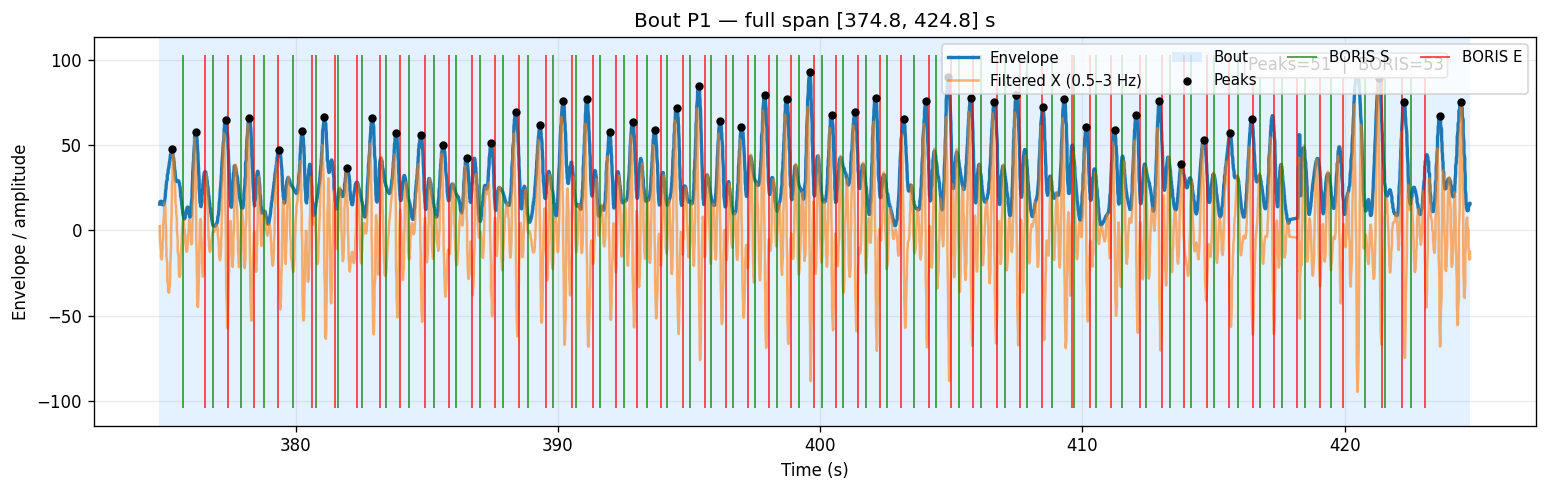

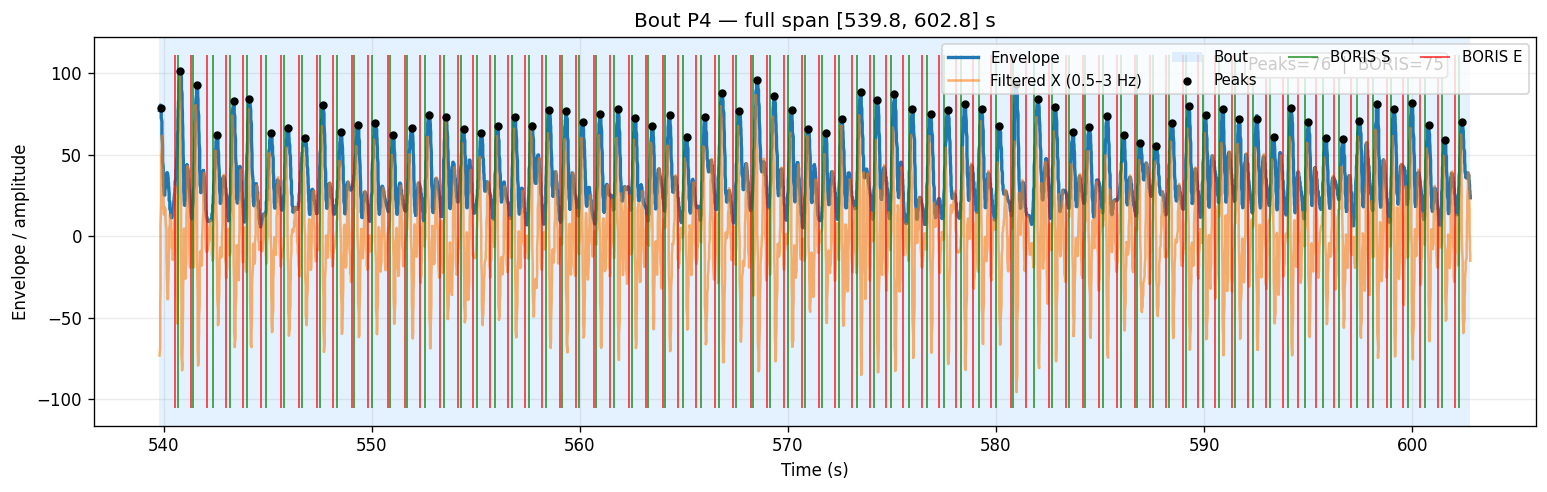

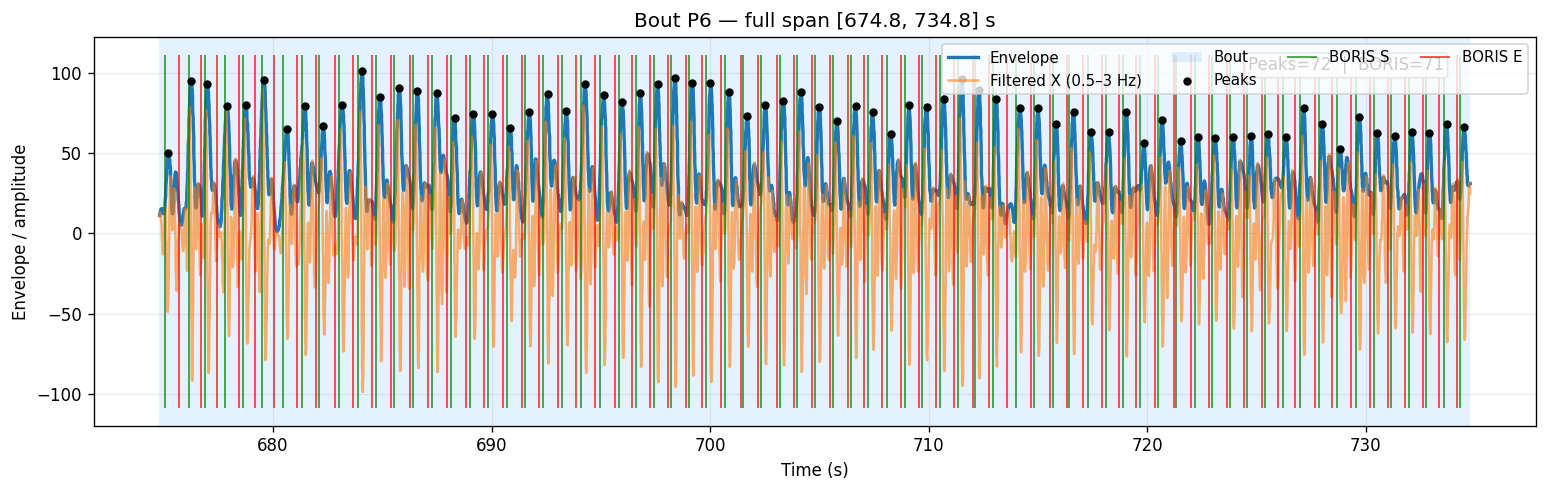

In [7]:

per_bout_counts = {}
for i in BOUT_IDS_TO_PLOT:
    a, b = VIDEO_BOUTS[i-1]
    a2, b2 = max(a, t_v[0]), min(b, t_v[-1])
    per_bout_counts[i] = plot_full_bout(i, a2, b2)



## 2) Zoomed (10 s) plots for P1, P4, P6 (with counts)


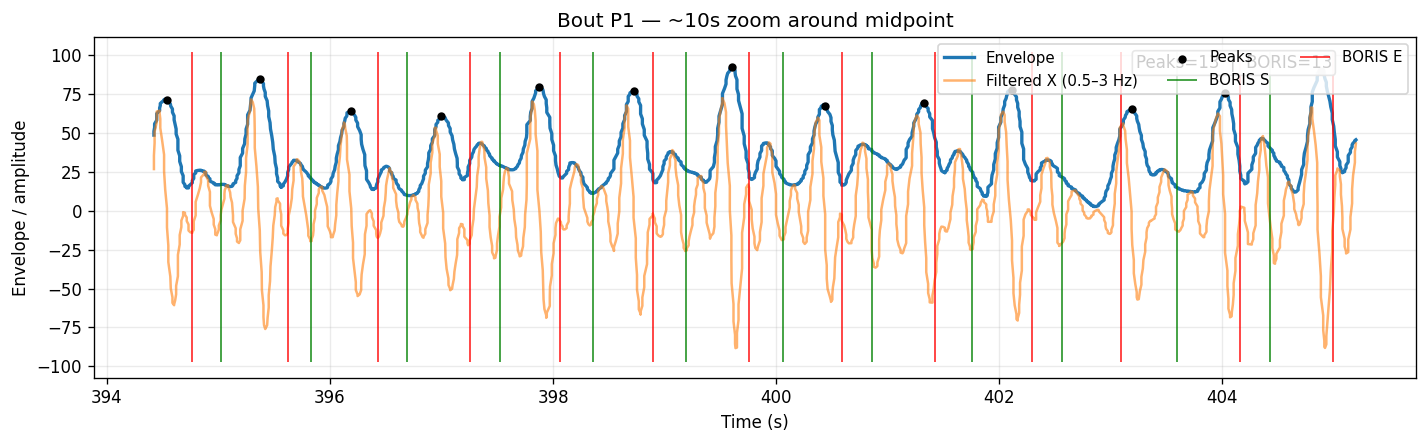

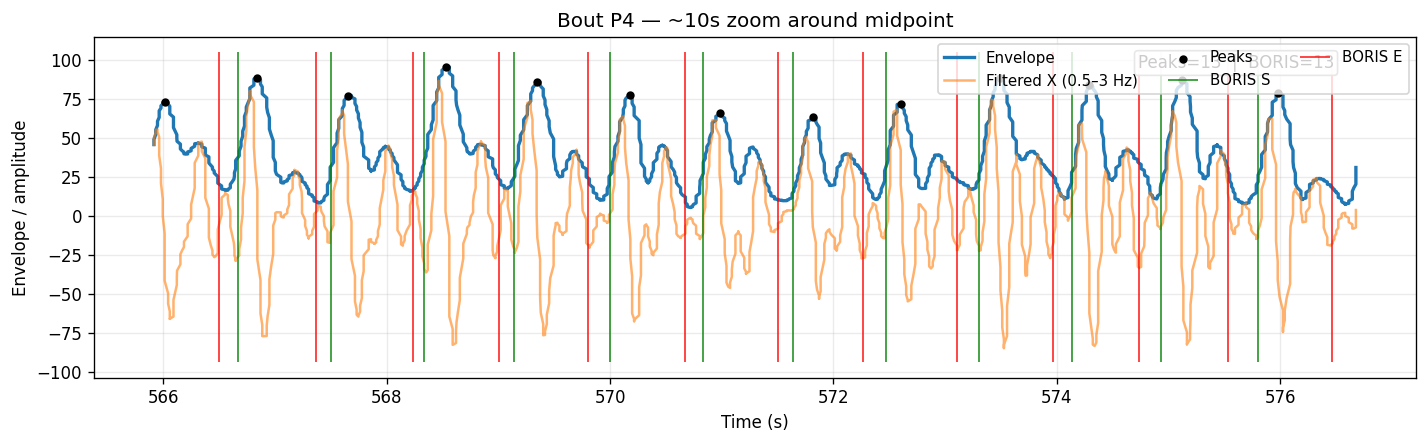

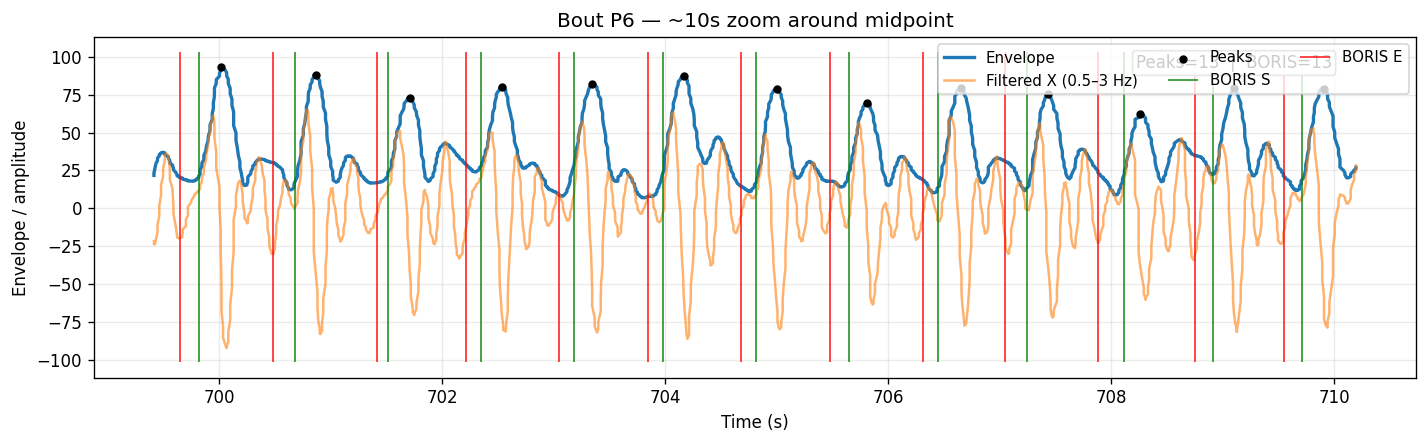

In [8]:

for i in BOUT_IDS_TO_PLOT:
    a, b = VIDEO_BOUTS[i-1]
    a2, b2 = max(a, t_v[0]), min(b, t_v[-1])
    _ = plot_zoom_bout(i, a2, b2, ZOOM_SECONDS, ZOOM_MARGIN_S)



## 3) One grouped bar chart — BORIS vs Peaks for **all** 10 bouts
Each bout gets two bars: **BORIS** (S→E midpoints inside the span) and **Peaks** (accelerometer).


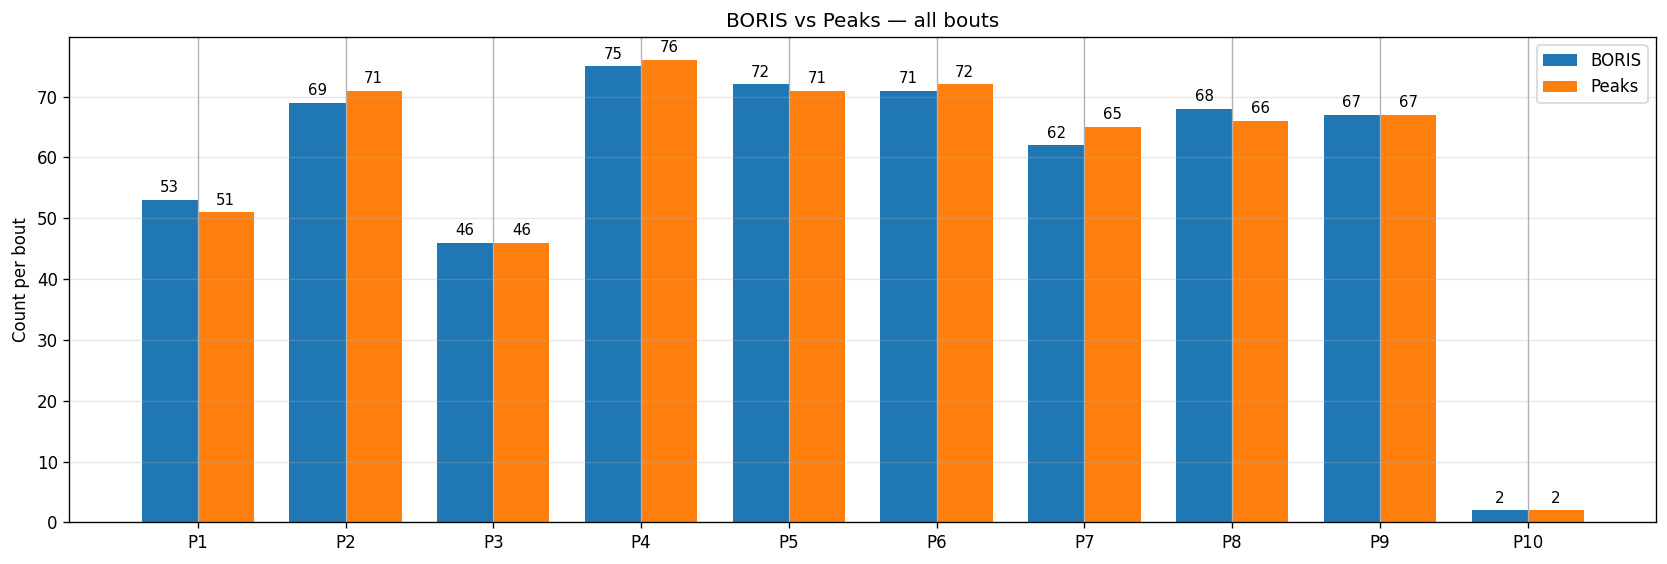

In [9]:

boris_counts = []
prog_counts  = []
labels = [f"P{i}" for i in range(1, len(VIDEO_BOUTS)+1)]
for i,(a,b) in enumerate(VIDEO_BOUTS, start=1):
    a2, b2 = max(a, t_v[0]), min(b, t_v[-1])
    boris_counts.append(count_pairs_midpoint_in_window(pairs, a2, b2))
    prog_counts.append(int(np.sum((t_peaks >= a2) & (t_peaks <= b2))))

xpos = np.arange(len(labels))
width = 0.38

fig, ax = plt.subplots(figsize=(14, 4.8))
bars1 = ax.bar(xpos - width/2, boris_counts, width, label="BORIS")
bars2 = ax.bar(xpos + width/2, prog_counts,  width, label="Peaks")

# annotate bar tops
for b in list(bars1) + list(bars2):
    ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.01*max(boris_counts+prog_counts),
            f"{int(b.get_height())}", ha="center", va="bottom", fontsize=9)

ax.set_xticks(xpos); ax.set_xticklabels(labels)
ax.set_ylabel("Count per bout"); ax.set_title("BORIS vs Peaks — all bouts")
ax.legend(loc="upper right"); ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()
